In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES= 5
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=5


## Functions

In [2]:
# 布林通道
def BOLL(data, index):
    days = 20
    if index == 1:
        md = 0
        mb = MA(data, index)
        up = mb + 2 * md
        dn = mb - 2 * md
    elif index >= days:
        temp = data[(index - days):index]
        md = np.sqrt(np.sum((temp['closePrice'][:] - temp['openPrice'][:])**2) / len(temp))
        mb = MA(data, index)
        up = mb + 2 * md
        dn = mb - 2 * md
    else:
        temp = data[:index]
        md = np.sqrt(np.sum((temp['closePrice'][:] - temp['openPrice'][:])**2) / len(temp))
        mb = MA(data, index)
        up = mb + 2 * md
        dn = mb - 2 * md
    return dn, mb, up

# RSV
def RSV(data, index):
    days = 9
    if index == 0:
        return 50
    elif index < days:
        rangeMin = data['minPrice'][:index].min()
        rangeMax = data['maxPrice'][:index].max()
    else:
        rangeMin = data['minPrice'][(index - days):index].min()
        rangeMax = data['maxPrice'][(index - days):index].max()
    diff = rangeMax - rangeMin
    if diff == 0:
        return 50
    return (data['closePrice'][index] - rangeMin) / (rangeMax - rangeMin) * 100

# PSY-心情指數
def PSY(data, index):
    days = 12
    if index >= days:
        temp = data['diff'][(index - days):index]
    else:
        temp = data['diff'][:index]
    return len(temp[temp > 0]) / len(temp) * 100

# 移動平均
def MA(data, index):
    days = 20
    if index >= days:
        ma = np.mean(data['closePrice'][(index - days):index])
    elif index == 0:
        ma = data['closePrice'][0]
    else:
        ma = np.mean(data['closePrice'][:index])
    return ma

# 動量指標
def MTM(data, index):
    days = 6
    if index >= days:
        mtm = data['closePrice'][index] - data['closePrice'][index - days]
    else:
        mtm = 0
    return mtm 

# KD線
def KLine(data):
    Kline = []
    for index in range(len(data)):
        if index == 0:
            Kline.append(RSV(data, index) * 1/3 + 50 * 2/3)
        else:
            Kline.append(RSV(data, index) * 1/3 + Kline[index - 1] * 2/3)
    return Kline

def DLine(data):
    Dline = []
    for index in range(len(data)):
        if index == 0:
            Dline.append(data['K'][index] * 1/3 + 50 * 2/3)
        else:
            Dline.append(data['K'][index] * 1/3 + Dline[index - 1] * 2/3)
    return Dline
def search_high(price):
    price = last_price.shift(1)
    signal = []
    if price > last_price:
        signal.append(1)
    else:
        signal.append(0)
    return signal


## Import data

In [3]:
dtypes = {'stockID':'str', 'date':'str', 'openPrice':'float64', 'maxPrice':'float64', 'minPrice':'float64',
          'closePrice':'float64', 'qty':'float64'}
dayData = pd.read_csv('/data/put_data/intern/Dennis/h1/TWH1080F.txt',
                      header = None, sep = '|', names = ['stockID', 'date', 'openPrice', 'maxPrice', 'minPrice', 'closePrice', 'qty'],
                      dtype = dtypes, date_parser = pd.to_datetime,
                      parse_dates = ['date'])

dayData.stockID = dayData.stockID.str.replace(" ","")
# stockRef = stockRef[0].str.split("|", expand = True)
# stockRef.columns = ['stockID', 'stockName', 'type']
# stockRef.stockID = stockRef.stockID.str.replace(" ","")
# stockRef.stockName = stockRef.stockName.str.replace(" ","")

In [4]:
day = dayData.loc[dayData.stockID == '2330']
day = day.set_index(['date'], drop = True)
day.drop(['stockID'], 1, inplace = True, errors = 'ignore')

## Add features

In [6]:
day['diff'] = day['closePrice'] - day['openPrice']
day['MTM'] = [MTM(day, i) for i in range(len(day))]
day['MA'] = [MA(day, i) for i in range(len(day))]
day['PSY'] = [PSY(day, i + 1) for i in range(len(day))]
listBOLL = pd.DataFrame([BOLL(day, i + 1) for i in range(len(day))])
listBOLL.set_index(day.index)
day['BOLL_lower'] = listBOLL.iloc[:,0].values
day['BOLL_mid'] = listBOLL.iloc[:,1].values
day['BOLL_upper'] = listBOLL.iloc[:,2].values
day['Lag1'] = (day['openPrice'] + day['closePrice']) / 2
day.Lag1 = day.Lag1.shift(-1)
day['Lag2'] = day.Lag1.shift(-1)
day.dropna(inplace = True)

In [28]:
# norm_c = preprocessing.StandardScaler()
# day_norm = day
# for each in day.columns:
#     day_norm[each] = norm_c.fit_transform(day_norm[each].values.reshape(-1,1))

In [7]:
norm_c = preprocessing.MinMaxScaler(feature_range = (0,1))
norm = preprocessing.MinMaxScaler(feature_range = (-1,1))
day_norm = day.copy()
for each in day_norm.columns:
    if each == 'diff':
        day_norm[each] = norm.fit_transform(day_norm[each].values.reshape(-1,1))
    else:
        day_norm[each] = norm_c.fit_transform(day_norm[each].values.reshape(-1,1))

In [8]:
split = pd.Timestamp("01-01-2012")
dayTrain = day_norm[:split]
dayTest = day_norm[split:]
x_train = dayTrain.drop(['diff'], axis = 1)
y_train = dayTrain[['diff']]
x_test = dayTest.drop(['diff'], axis = 1)
y_test = dayTest[['diff']]

In [31]:
# norm = preprocessing.MinMaxScaler(feature_range = (0, 1))
# norm_q = preprocessing.MinMaxScaler(feature_range = (0, 5))
# norm_c = preprocessing.StandardScaler()
# for each in x_train.columns:
#     x_train[each] = norm_c.fit_transform(x_train[each].values.reshape(-1,1))
#     x_test[each] = norm_c.transform(x_test[each].values.reshape(-1,1))

# y_train = norm_c.fit_transform(y_train.values.reshape(-1,1))
# y_test = norm_c.transform(y_test.values.reshape(-1,1))
#     if each == 'diff':
#         day[each] = norm_c.fit_transform(day[each].values.reshape(-1,1))
#     elif each == 'qty':
#         day[each] = norm_c.fit_transform(day[each].values.reshape(-1,1))
#     else:
#         day[each] = norm_c.fit_transform(day[each].values.reshape(-1,1))

In [9]:
x_train = x_train.values.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = x_test.values.reshape(x_test.shape[0], 1, x_test.shape[1])

In [10]:
y_train = y_train.values.reshape((y_train.shape[0], y_train.shape[1]))

y_test = y_test.values.reshape((y_test.shape[0], y_test.shape[1]))

## Build model - difference between closePrice and openPrice

In [11]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import LSTM
from keras import initializers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from keras import regularizers
import keras.backend as K
import os

Using TensorFlow backend.


In [35]:
def build():
    global x_train
    d = 0.1
    length = x_train.shape[0]
    feat = x_train.shape[2]
    ki = 'lecun_uniform'
    act = 'tanh'
    model = Sequential()
    model.add(LSTM(69, input_shape = (1, feat), activation = act, activity_regularizer = regularizers.l2(0.0001),
                   kernel_initializer = ki, return_sequences=True))
    model.add(LSTM(69, input_shape = (1, feat), activation = act, activity_regularizer = regularizers.l2(0.0001),
                   kernel_initializer = ki, return_sequences=True))
    model.add(LSTM(91, input_shape = (1, feat), activation = act, activity_regularizer = regularizers.l2(0.0001),
                   kernel_initializer = ki, return_sequences=True))
    model.add(LSTM(130, input_shape = (1, feat), activation = act, activity_regularizer = regularizers.l2(0.0001),
                   kernel_initializer = ki, return_sequences=True))
    model.add(LSTM(169, input_shape = (1, feat), activation = act, activity_regularizer = regularizers.l2(0.0001),
                   kernel_initializer = ki, return_sequences=True))
    model.add(LSTM(195, input_shape = (1, feat), activation = act, activity_regularizer = regularizers.l2(0.0001),
                   kernel_initializer = ki, return_sequences=False))
    model.add(Dense(195))
    model.add(Dense(169))
    model.add(Dense(130))
    model.add(Dense(91))
    model.add(Dense(1))
    opt = Nadam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.99)
#     opt = SGD(lr = 0.1, decay = 1e-6, nesterov = False)
#     opt = RMSprop(lr = 0.002, rho = 0.9, decay = 0.0)
#     opt = 'nadam'
    model.compile(loss = 'mean_squared_error', optimizer = opt)
    return model

In [36]:
K.clear_session()
model = build()
early_stop = EarlyStopping(monitor = 'loss', patience = 100, verbose = 1, min_delta = 0)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 69)             22908     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 69)             38364     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 91)             58604     
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 130)            115440    
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 169)            202800    
_________________________________________________________________
lstm_6 (LSTM)                (None, 195)               284700    
_________________________________________________________________
dense_1 (Dense)              (None, 195)               38220     
__________

In [37]:
model_name = 'predict_model.h5'
save_dir = os.path.join(os.getcwd(), 'model')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor = 'loss', save_best_only = True)

In [38]:
history = model.fit(x_train, y_train, batch_size = 256, epochs = 1000, callbacks = [checkpoint],
          shuffle = False, validation_split = 0.2
                   )

Train on 3593 samples, validate on 899 samples
Epoch 1/1000
3593/3593 [==============================] - 3s - loss: 0.0301 - val_loss: 0.0147
Epoch 2/1000
3593/3593 [==============================] - 0s - loss: 0.0257 - val_loss: 0.0083ss: 0
Epoch 3/1000
3593/3593 [==============================] - 0s - loss: 0.0236 - val_loss: 0.0076
Epoch 4/1000
3593/3593 [==============================] - 0s - loss: 0.0226 - val_loss: 0.0072
Epoch 5/1000
3593/3593 [==============================] - 0s - loss: 0.0218 - val_loss: 0.0068
Epoch 6/1000
3593/3593 [==============================] - 0s - loss: 0.0213 - val_loss: 0.0064
Epoch 7/1000
3593/3593 [==============================] - 0s - loss: 0.0208 - val_loss: 0.0060ss: 0.02
Epoch 8/1000
3593/3593 [==============================] - 0s - loss: 0.0205 - val_loss: 0.0057
Epoch 9/1000
3593/3593 [==============================] - 0s - loss: 0.0203 - val_loss: 0.0055
Epoch 10/1000
3593/3593 [==============================] - 0s - loss: 0.0201 - val_lo

3593/3593 [==============================] - 0s - loss: 0.0137 - val_loss: 0.0020
Epoch 170/1000
3593/3593 [==============================] - 0s - loss: 0.0091 - val_loss: 8.7595e-04
Epoch 171/1000
3593/3593 [==============================] - 0s - loss: 0.0140 - val_loss: 0.0024
Epoch 172/1000
3593/3593 [==============================] - 0s - loss: 0.0145 - val_loss: 0.0021
Epoch 173/1000
3593/3593 [==============================] - 0s - loss: 0.0105 - val_loss: 0.0010
Epoch 174/1000
3593/3593 [==============================] - 0s - loss: 0.0190 - val_loss: 0.0028
Epoch 175/1000
3593/3593 [==============================] - 0s - loss: 0.0181 - val_loss: 0.0029
Epoch 176/1000
3593/3593 [==============================] - 0s - loss: 0.0179 - val_loss: 0.0027
Epoch 177/1000
3593/3593 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0025
Epoch 178/1000
3593/3593 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0022
Epoch 179/1000
3593/3593 [===============

3593/3593 [==============================] - 0s - loss: 0.0065 - val_loss: 4.2437e-04
Epoch 333/1000
3593/3593 [==============================] - 0s - loss: 0.0118 - val_loss: 9.5177e-04
Epoch 334/1000
3593/3593 [==============================] - 0s - loss: 0.0038 - val_loss: 2.9401e-04
Epoch 335/1000
3593/3593 [==============================] - 0s - loss: 0.0025 - val_loss: 5.2685e-04
Epoch 336/1000
3593/3593 [==============================] - 0s - loss: 0.0016 - val_loss: 2.9604e-04
Epoch 337/1000
3593/3593 [==============================] - 0s - loss: 0.0041 - val_loss: 5.5363e-04
Epoch 338/1000
3593/3593 [==============================] - 0s - loss: 0.0077 - val_loss: 6.0678e-04
Epoch 339/1000
3593/3593 [==============================] - 0s - loss: 0.0048 - val_loss: 4.1068e-04
Epoch 340/1000
3593/3593 [==============================] - 0s - loss: 0.0024 - val_loss: 4.1331e-04
Epoch 341/1000
3593/3593 [==============================] - 0s - loss: 0.0020 - val_loss: 4.8185e-04
Epoch

3593/3593 [==============================] - 0s - loss: 0.0041 - val_loss: 4.2961e-04
Epoch 495/1000
3593/3593 [==============================] - 0s - loss: 0.0038 - val_loss: 2.6834e-04
Epoch 496/1000
3593/3593 [==============================] - 0s - loss: 0.0018 - val_loss: 2.8177e-04
Epoch 497/1000
3593/3593 [==============================] - 0s - loss: 9.0301e-04 - val_loss: 2.6991e-04
Epoch 498/1000
3593/3593 [==============================] - 0s - loss: 9.3571e-04 - val_loss: 2.6491e-04
Epoch 499/1000
3593/3593 [==============================] - 0s - loss: 8.6289e-04 - val_loss: 2.6189e-04
Epoch 500/1000
3593/3593 [==============================] - 0s - loss: 8.5260e-04 - val_loss: 2.3741e-04
Epoch 501/1000
3593/3593 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0012
Epoch 502/1000
3593/3593 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0064
Epoch 503/1000
3593/3593 [==============================] - 0s - loss: 0.0082 - val_loss: 8.1384e-

3593/3593 [==============================] - 0s - loss: 0.0050 - val_loss: 3.0732e-04
Epoch 655/1000
3593/3593 [==============================] - 0s - loss: 0.0021 - val_loss: 2.2287e-04
Epoch 656/1000
3593/3593 [==============================] - 0s - loss: 8.3604e-04 - val_loss: 2.1326e-04
Epoch 657/1000
3593/3593 [==============================] - 0s - loss: 6.6648e-04 - val_loss: 2.5053e-04
Epoch 658/1000
3593/3593 [==============================] - 0s - loss: 6.2430e-04 - val_loss: 2.1630e-04
Epoch 659/1000
3593/3593 [==============================] - 0s - loss: 9.2244e-04 - val_loss: 2.3548e-04
Epoch 660/1000
3593/3593 [==============================] - 0s - loss: 0.0021 - val_loss: 5.4963e-04
Epoch 661/1000
3593/3593 [==============================] - 0s - loss: 0.0037 - val_loss: 6.5576e-04
Epoch 662/1000
3593/3593 [==============================] - 0s - loss: 0.0045 - val_loss: 3.2763e-04
Epoch 663/1000
3593/3593 [==============================] - 0s - loss: 0.0024 - val_loss: 

3593/3593 [==============================] - 0s - loss: 0.0017 - val_loss: 1.8831e-04
Epoch 735/1000
3593/3593 [==============================] - 0s - loss: 7.2785e-04 - val_loss: 1.8355e-04
Epoch 736/1000
3593/3593 [==============================] - 0s - loss: 5.8479e-04 - val_loss: 2.1492e-04
Epoch 737/1000
3593/3593 [==============================] - 0s - loss: 5.4582e-04 - val_loss: 1.8619e-04
Epoch 738/1000
3593/3593 [==============================] - 0s - loss: 0.0011 - val_loss: 2.2465e-04
Epoch 739/1000
3593/3593 [==============================] - 0s - loss: 0.0024 - val_loss: 3.0741e-04
Epoch 740/1000
3593/3593 [==============================] - 0s - loss: 0.0040 - val_loss: 3.1709e-04
Epoch 741/1000
3593/3593 [==============================] - 0s - loss: 0.0052 - val_loss: 3.7484e-04
Epoch 742/1000
3593/3593 [==============================] - 0s - loss: 0.0031 - val_loss: 2.4698e-04
Epoch 743/1000
3593/3593 [==============================] - 0s - loss: 0.0011 - val_loss: 1.88

3593/3593 [==============================] - 0s - loss: 7.9296e-04 - val_loss: 1.4730e-04
Epoch 894/1000
3593/3593 [==============================] - 0s - loss: 6.1146e-04 - val_loss: 1.5554e-04
Epoch 895/1000
3593/3593 [==============================] - 0s - loss: 4.8210e-04 - val_loss: 1.5239e-04
Epoch 896/1000
3593/3593 [==============================] - 0s - loss: 7.2111e-04 - val_loss: 2.3095e-04
Epoch 897/1000
3593/3593 [==============================] - 0s - loss: 0.0016 - val_loss: 2.9943e-04
Epoch 898/1000
3593/3593 [==============================] - 0s - loss: 0.0034 - val_loss: 4.1691e-04
Epoch 899/1000
3593/3593 [==============================] - 0s - loss: 0.0049 - val_loss: 3.7412e-04
Epoch 900/1000
3593/3593 [==============================] - 0s - loss: 0.0034 - val_loss: 3.9975e-04
Epoch 901/1000
3593/3593 [==============================] - 0s - loss: 0.0022 - val_loss: 1.8646e-04
Epoch 902/1000
3593/3593 [==============================] - 0s - loss: 7.1426e-04 - val_lo

## Plot graphs 

In [39]:
all_test = day.drop(['diff'], axis = 1)
all_test = all_test.values.reshape(all_test.shape[0], 1, all_test.shape[1])
all_diff = day[['diff']]
all_diff = all_diff.values.reshape(all_diff.shape[0], all_diff.shape[1])

RMSE on Train set is:	0.029
RMSE on Test set is:	0.043
Average Error: 0.032628
Accuracy: -inf%


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


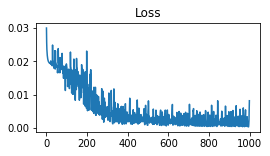

0.000347960398533


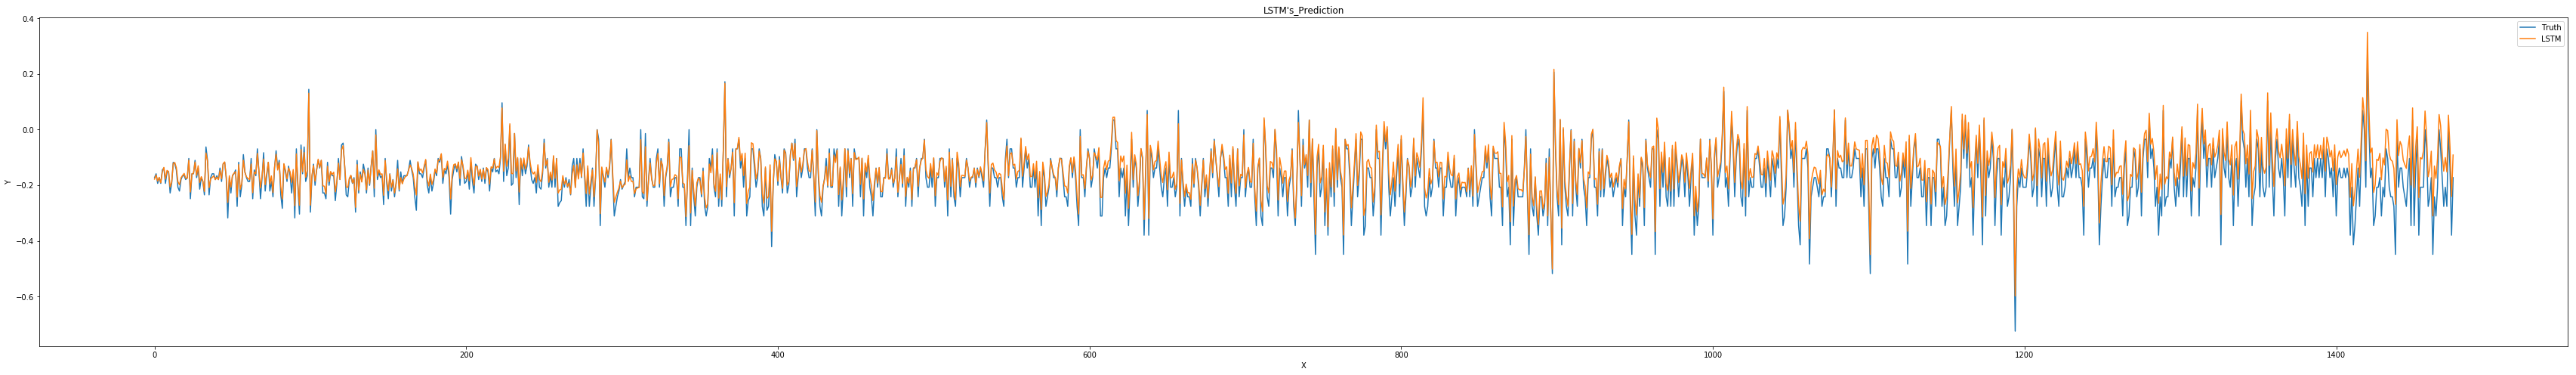

In [113]:
# from sklearn.metrics import r2_score
# def adj_r2_score(r2, n, k):
#     return 1-((1-r2)*((n-1)/(n-k-1)))

# print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
# r2_train = r2_score(y_train, y_train_pred_lstm)
# print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, x_train.shape[0], x_train.shape[1])))
# print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
# r2_test = r2_score(y_test, y_pred_test_lstm)
# print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, x_test.shape[0], x_test.shape[1])))

    
from sklearn.metrics import mean_squared_error as mse
y_pred_test_lstm = model.predict(x_test)
y_train_pred_lstm = model.predict(x_train)
# all_pred = model.predict(all_test)
print("RMSE on Train set is:\t{:0.3f}".format(np.sqrt(mse(y_train, y_train_pred_lstm))))
print("RMSE on Test set is:\t{:0.3f}".format(np.sqrt(mse(y_test, y_pred_test_lstm))))

def evaluate(model, x_test, y_test):
    predict = model.predict(x_test)
    errors = abs(predict - y_test)
    mape = 100 * np.abs(np.mean(errors / y_test)) / len(y_test)
    acc = 100 - mape
    print('Average Error: {:0.6f}'.format(np.mean(errors)))
    print('Accuracy: {:0.2f}%'.format(acc))
    return predict
predict = evaluate(model, x_test, y_test)


#### summarize history for loss
# plt.subplot(2, 1, 1)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])

# plt.title('model loss')

# plt.ylabel('loss')
# plt.xlabel('epoch')

# plt.legend(['train', 'val'], loc = 'lower left')
# plt.show()
y_test_result= np.array(y_test)
y_lstm_result = y_pred_test_lstm
# y_lstm_result = y_train_pred_lstm[:, 5]
# print("accuracy : {}".format(max(history.history['acc'])))
plt.figure(figsize = (4,2))
plt.plot(history.history['loss'])
plt.title("Loss")
plt.show()
print(min(history.history['loss']))

plt.figure(figsize = (60,8))
plt.plot(y_test_result, label='Truth')
plt.plot(y_lstm_result, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# all_truth = np.array(day['diff'])

# plt.figure(figsize = (150,8))
# plt.plot(all_truth, label='Truth')
# plt.plot(all_pred, label='LSTM on all')
# plt.title("LSTM on All")
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.show()


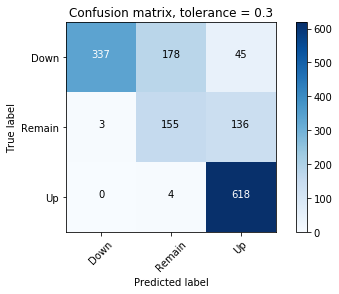

accuracy: 0.752032520325


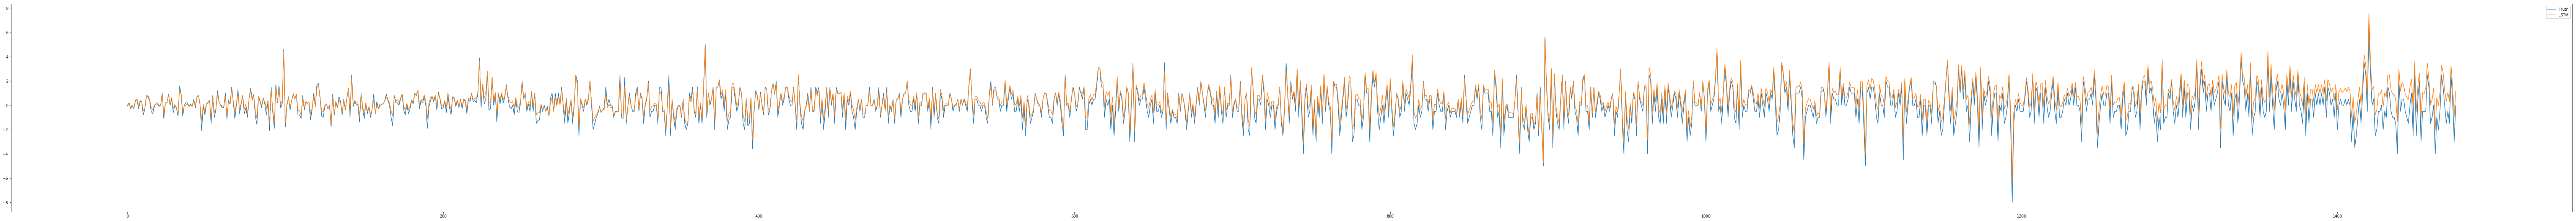

In [104]:
from sklearn.metrics import confusion_matrix
import itertools
y_test_orig = norm.inverse_transform(y_test)
y_pred_orig = norm.inverse_transform(y_pred_test_lstm)


signal_test = []
signal_pred = []
for i in range(len(y_test_orig)):
    if abs(y_test_orig[i]) <= 0.3:
        signal_test.append(0)
    elif y_test_orig[i] > 0.3:
        signal_test.append(1)
    else:
        signal_test.append(-1)
for i in range(len(y_pred_orig)):
    if abs(y_pred_orig[i]) <= 0.3:
        signal_pred.append(0)
    elif y_pred_orig[i] > 0.3:
        signal_pred.append(1)
    else:
        signal_pred.append(-1)
        
cmat = confusion_matrix(signal_test, signal_pred, labels = [-1, 0, 1])
# print("Actual \\ Predicted")
# print(cmat)
cmap = plt.cm.Blues
title = 'Confusion matrix, tolerance = 0.3'
classes = ['Down', 'Remain', 'Up']
plt.figure()
plt.imshow(cmat, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cmat.max() / 2.
for i, j in itertools.product(range(cmat.shape[0]), range(cmat.shape[1])):
    plt.text(j, i, format(cmat[i, j], fmt),
             horizontalalignment="center",
             color="white" if cmat[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


accuracy = cmat.diagonal().sum()/cmat.sum()
print('accuracy:',accuracy)


        
plt.figure(figsize = (120,10))
plt.plot(y_test_orig[:], label = 'Truth')
plt.plot(y_pred_orig[:], label = 'LSTM')
plt.legend()
plt.show()

# Prediction accuracy (threshold = 0.3) = 65.1%

In [76]:
DTD = cmat[0,0]
DTR = cmat[0,1]
DTU = cmat[0,2]
RTD = cmat[1,0]
RTR = cmat[1,1]
RTU = cmat[1,2]
UTD = cmat[2,0]
UTR = cmat[2,1]
UTU = cmat[2,2]

accuracy = cmat.diagonal().sum()/cmat.sum()
#precision :which is classified to True really belongs to True
def recall(x):
        recallrate = cmat[x,x]/cmat[0,:].sum()
        return recallrate
    
def precision(x):
    precisionrate = cmat[x,x]/cmat[:,0].sum()
    return precisionrate


In [81]:
num = ['down','remain','up']
for x in range(len(num)):
    showrec = recall(x)
    showpre = precision(x)
    print('recallrate of',num[x],'is',showrec)
    print('precision of',num[x],'is',showpre)

recallrate of down is 0.601785714286
precision of down is 0.991176470588
recallrate of remain is 0.276785714286
precision of remain is 0.455882352941
recallrate of up is 1.10357142857
precision of up is 1.81764705882


In [102]:
num = ['down','remain','up']
for x in range(len(num)):
    showrec = recall(x)
    showpre = precision(x)
    print('The',num[x],  "recallrate : {rec},      precisionrate:{pre}".format(rec=showrec,pre =showpre))

The down recallrate : 0.6017857142857143,      precisionrate:0.9911764705882353
The remain recallrate : 0.2767857142857143,      precisionrate:0.45588235294117646
The up recallrate : 1.1035714285714286,      precisionrate:1.8176470588235294
